In [15]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [16]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
from get_dataset import GiMeFiveDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
# rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/train/',
#                             transform=transform)

rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/FER2013/train_FER_labels.csv',
                            img_dir='archive/FER2013/train/',
                            transform=transform)

# rafdb_dataset_train = GiMeFiveDataset(csv_file='data/train_labels.csv',
#                             img_dir='data/train/',
#                             transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = GiMeFiveDataset(csv_file='data/valid_labels.csv',
                            img_dir='data/valid',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

# rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/test/',
#                             transform=transform)

rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/FER2013/test_FER_labels.csv',
                            img_dir='archive/FER2013/test/',
                            transform=transform)

# rafdb_dataset_test = GiMeFiveDataset(csv_file='data/test_labels.csv',
#                             img_dir='data/test/',
#                             transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [18]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [20]:
# # Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [21]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

def EmotionClassifierResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

model = EmotionClassifierResNet34().to(device)


In [23]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 21287750


In [24]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

patience = 10
best_val_acc = 0  
patience_counter = 0

num_epochs = 80

In [25]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/80: 100%|██████████| 1484/1484 [02:09<00:00, 11.44it/s]


Epoch 1, Train Loss: 1.463217015616656, Train Accuracy: 0.404026789099027, Test Loss: 1.2973912888637154, Test Accuracy: 0.482671601615074, Validation Loss: 2.1666853427886963, Validation Accuracy: 0.2938230383973289


Epoch 2/80: 100%|██████████| 1484/1484 [02:08<00:00, 11.55it/s]


Epoch 2, Train Loss: 1.2001168440696042, Train Accuracy: 0.521966218777642, Test Loss: 1.1331229995815986, Test Accuracy: 0.5511440107671601, Validation Loss: 2.0334883175398173, Validation Accuracy: 0.327212020033389


Epoch 3/80: 100%|██████████| 1484/1484 [02:06<00:00, 11.73it/s]


Epoch 3, Train Loss: 1.0662985924440573, Train Accuracy: 0.5761762352049198, Test Loss: 1.1023689806461334, Test Accuracy: 0.5689771197846568, Validation Loss: 1.8885865964387591, Validation Accuracy: 0.3789649415692821


Epoch 4/80: 100%|██████████| 1484/1484 [02:05<00:00, 11.78it/s]


Epoch 4, Train Loss: 0.9625965546204074, Train Accuracy: 0.625121098521545, Test Loss: 0.995077510194112, Test Accuracy: 0.6199528936742934, Validation Loss: 2.156569756959614, Validation Accuracy: 0.39232053422370616


Epoch 5/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.63it/s]


Epoch 5, Train Loss: 0.8827909035984718, Train Accuracy: 0.6597026241523104, Test Loss: 0.9968581025749045, Test Accuracy: 0.6078398384925976, Validation Loss: 2.3927174116435803, Validation Accuracy: 0.34891485809682804
No improvement in validation accuracy for 1 epochs.


Epoch 6/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.64it/s]


Epoch 6, Train Loss: 0.8111346729722306, Train Accuracy: 0.6878817236005224, Test Loss: 0.9985000097783663, Test Accuracy: 0.6229811574697174, Validation Loss: 2.117997721621865, Validation Accuracy: 0.4023372287145242


Epoch 7/80: 100%|██████████| 1484/1484 [02:06<00:00, 11.70it/s]


Epoch 7, Train Loss: 0.7366713250502743, Train Accuracy: 0.7195568847142075, Test Loss: 1.046479895430547, Test Accuracy: 0.6181022880215343, Validation Loss: 2.2665459356809916, Validation Accuracy: 0.4290484140233723


Epoch 8/80: 100%|██████████| 1484/1484 [02:02<00:00, 12.07it/s]


Epoch 8, Train Loss: 0.6815103991835747, Train Accuracy: 0.7404068910323912, Test Loss: 1.013073210834816, Test Accuracy: 0.6236541049798116, Validation Loss: 2.6204663860170463, Validation Accuracy: 0.3806343906510851
No improvement in validation accuracy for 1 epochs.


Epoch 9/80: 100%|██████████| 1484/1484 [02:02<00:00, 12.11it/s]


Epoch 9, Train Loss: 0.6021942036311743, Train Accuracy: 0.7777262962806959, Test Loss: 1.111262060854564, Test Accuracy: 0.6221399730820996, Validation Loss: 2.807740744791533, Validation Accuracy: 0.3639398998330551
No improvement in validation accuracy for 2 epochs.


Epoch 10/80: 100%|██████████| 1484/1484 [02:03<00:00, 12.06it/s]


Epoch 10, Train Loss: 0.5457313494791962, Train Accuracy: 0.7958384229813403, Test Loss: 1.089598405265039, Test Accuracy: 0.6228129205921938, Validation Loss: 2.1665764482397782, Validation Accuracy: 0.4240400667779633
No improvement in validation accuracy for 3 epochs.


Epoch 11/80: 100%|██████████| 1484/1484 [02:02<00:00, 12.09it/s]


Epoch 11, Train Loss: 0.4885805852414985, Train Accuracy: 0.8211954003622426, Test Loss: 1.0968271374892724, Test Accuracy: 0.6288694481830417, Validation Loss: 2.433004369861201, Validation Accuracy: 0.4323873121869783


Epoch 12/80: 100%|██████████| 1484/1484 [02:02<00:00, 12.08it/s]


Epoch 12, Train Loss: 0.425014902932966, Train Accuracy: 0.8452044985468178, Test Loss: 1.2142215089031285, Test Accuracy: 0.6303835800807537, Validation Loss: 2.5263002263872245, Validation Accuracy: 0.41402337228714525
No improvement in validation accuracy for 1 epochs.


Epoch 13/80: 100%|██████████| 1484/1484 [02:06<00:00, 11.72it/s]


Epoch 13, Train Loss: 0.38866762928865506, Train Accuracy: 0.8614632913525125, Test Loss: 1.1632243949489327, Test Accuracy: 0.6419919246298789, Validation Loss: 2.6834987652929208, Validation Accuracy: 0.39065108514190316
No improvement in validation accuracy for 2 epochs.


Epoch 14/80: 100%|██████████| 1484/1484 [02:03<00:00, 12.04it/s]


Epoch 14, Train Loss: 0.3319963720072352, Train Accuracy: 0.8792384482540753, Test Loss: 1.3155234243898521, Test Accuracy: 0.6206258411843876, Validation Loss: 2.815531661635951, Validation Accuracy: 0.4006677796327212
No improvement in validation accuracy for 3 epochs.


Epoch 15/80: 100%|██████████| 1484/1484 [02:06<00:00, 11.73it/s]


Epoch 15, Train Loss: 0.3039694259801724, Train Accuracy: 0.8935596647150499, Test Loss: 1.2410292275330073, Test Accuracy: 0.6428331090174967, Validation Loss: 3.2830804586410522, Validation Accuracy: 0.38397328881469117
No improvement in validation accuracy for 4 epochs.


Epoch 16/80: 100%|██████████| 1484/1484 [02:08<00:00, 11.53it/s]


Epoch 16, Train Loss: 0.26247615759032517, Train Accuracy: 0.9083020934248768, Test Loss: 1.3181856701360835, Test Accuracy: 0.6401413189771198, Validation Loss: 3.300077052492844, Validation Accuracy: 0.38397328881469117
No improvement in validation accuracy for 5 epochs.


Epoch 17/80: 100%|██████████| 1484/1484 [02:04<00:00, 11.96it/s]


Epoch 17, Train Loss: 0.22727762331346407, Train Accuracy: 0.9203908849669349, Test Loss: 1.3948049413951575, Test Accuracy: 0.650235531628533, Validation Loss: 3.7680424514569735, Validation Accuracy: 0.41235392320534225
No improvement in validation accuracy for 6 epochs.


Epoch 18/80: 100%|██████████| 1484/1484 [02:03<00:00, 12.06it/s]


Epoch 18, Train Loss: 0.20217132948984134, Train Accuracy: 0.9304157364896172, Test Loss: 1.3945133976377948, Test Accuracy: 0.6421601615074024, Validation Loss: 2.8767480693365397, Validation Accuracy: 0.4357262103505843


Epoch 19/80: 100%|██████████| 1484/1484 [02:03<00:00, 12.04it/s]


Epoch 19, Train Loss: 0.18011427456305948, Train Accuracy: 0.9394717998399393, Test Loss: 1.4191856507633773, Test Accuracy: 0.655114401076716, Validation Loss: 3.7289480221898934, Validation Accuracy: 0.38731218697829717
No improvement in validation accuracy for 1 epochs.


Epoch 20/80: 100%|██████████| 1484/1484 [02:10<00:00, 11.39it/s]


Epoch 20, Train Loss: 0.1624495662209726, Train Accuracy: 0.9446948317257066, Test Loss: 1.4582965745370315, Test Accuracy: 0.6527590847913862, Validation Loss: 3.499940094194914, Validation Accuracy: 0.39232053422370616
No improvement in validation accuracy for 2 epochs.


Epoch 21/80: 100%|██████████| 1484/1484 [02:11<00:00, 11.31it/s]


Epoch 21, Train Loss: 0.14120309693660998, Train Accuracy: 0.9536245314013732, Test Loss: 1.6274297542127842, Test Accuracy: 0.6460296096904441, Validation Loss: 3.8839156094350313, Validation Accuracy: 0.39565943238731216
No improvement in validation accuracy for 3 epochs.


Epoch 22/80: 100%|██████████| 1484/1484 [02:10<00:00, 11.37it/s]


Epoch 22, Train Loss: 0.12768567971476652, Train Accuracy: 0.9576681689903542, Test Loss: 1.6443492565566915, Test Accuracy: 0.6504037685060565, Validation Loss: 4.164890722224587, Validation Accuracy: 0.4056761268781302
No improvement in validation accuracy for 4 epochs.


Epoch 23/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.67it/s]


Epoch 23, Train Loss: 0.1253115275438255, Train Accuracy: 0.9580893812392064, Test Loss: 1.4891332190356128, Test Accuracy: 0.650235531628533, Validation Loss: 3.3865439829073454, Validation Accuracy: 0.4040066777963272
No improvement in validation accuracy for 5 epochs.


Epoch 24/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.65it/s]


Epoch 24, Train Loss: 0.10455916365599159, Train Accuracy: 0.9665557474411356, Test Loss: 1.5931976620339938, Test Accuracy: 0.6576379542395693, Validation Loss: 4.020737855057967, Validation Accuracy: 0.4056761268781302
No improvement in validation accuracy for 6 epochs.


Epoch 25/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.64it/s]


Epoch 25, Train Loss: 0.09753858267225769, Train Accuracy: 0.9679036266374627, Test Loss: 1.6264074709809695, Test Accuracy: 0.6488896366083445, Validation Loss: 3.898941761568973, Validation Accuracy: 0.4006677796327212
No improvement in validation accuracy for 7 epochs.


Epoch 26/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.68it/s]


Epoch 26, Train Loss: 0.08642348343519948, Train Accuracy: 0.9724948401499516, Test Loss: 1.638769205191776, Test Accuracy: 0.6576379542395693, Validation Loss: 3.9317925791991386, Validation Accuracy: 0.4040066777963272
No improvement in validation accuracy for 8 epochs.


Epoch 27/80: 100%|██████████| 1484/1484 [02:06<00:00, 11.69it/s]


Epoch 27, Train Loss: 0.08323610848292985, Train Accuracy: 0.9727475674992628, Test Loss: 1.7326309884455862, Test Accuracy: 0.6509084791386271, Validation Loss: 4.033361309453061, Validation Accuracy: 0.41903171953255425
No improvement in validation accuracy for 9 epochs.


Epoch 28/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.61it/s]


Epoch 28, Train Loss: 0.07330663666296047, Train Accuracy: 0.9763278716145065, Test Loss: 1.8214088416069536, Test Accuracy: 0.6467025572005384, Validation Loss: 4.372825490800958, Validation Accuracy: 0.38898163606010017
No improvement in validation accuracy for 10 epochs.


Epoch 29/80: 100%|██████████| 1484/1484 [02:07<00:00, 11.64it/s]


Epoch 29, Train Loss: 0.07537003555328044, Train Accuracy: 0.9759066593656543, Test Loss: 1.6569293415361186, Test Accuracy: 0.6714333781965006, Validation Loss: 4.243412877383985, Validation Accuracy: 0.41068447412353926
No improvement in validation accuracy for 11 epochs.
Stopping early due to lack of improvement in validation accuracy.


ValueError: x and y must have same first dimension, but have shapes (43,) and (29,)

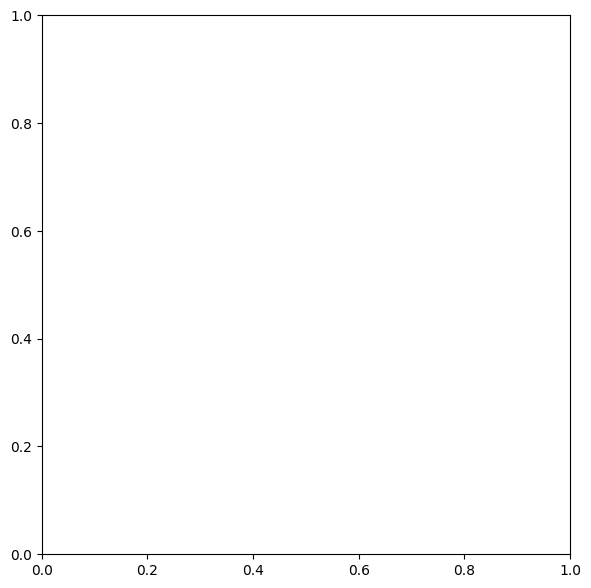

In [26]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 44), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 44), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 44), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses of ResNet34 on FER2013') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 44), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 44), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 44), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies of ResNet34 on FER2013') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 44), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_res34_fer.csv', index=False) # change this CSV